# Analysis of Robustness Check

Analyzing the effectiveness of the robustness check method via CLIP. A high level overview of how CLIP is used can be seen in the diagram below:

"insert image"

### Initialisation

Import Packages

In [1]:
import pandas as pd 
import json
from sklearn.metrics import auc, PrecisionRecallDisplay
from os import makedirs
import matplotlib.pyplot as plt

Define configurations.

In [2]:
val_results_path = '../data/from_server/using_lowest_train_cos_sim/val_robustness_check_results.json'
class_mapping_path = '../data/from_server/modified_class_mapping.json'
lowest_train_thresholds_path = '../data/from_server/using_lowest_train_cos_sim/train_robustness_thresholds.json'
val_robustness_folder = '../data/from_server/robustness_check/val'
train_robustness_folder = '../data/from_server/robustness_check/train'

### Hypothesis 1

The robustness check via CLIP can be seen as a binary classification problem for each class. For every class, images in the class can be seen as positive while images from the other 999 classes can be seen as negative. For this notebook's analysis on robustness checks, these negative class images can be used to simulate new images being added to a class.

Within each class, the training image that has image embeddings with the lowest cosine similarity score to the text embeddings of the class name can be used as a threshold to check for new images to be added to the class as seen in the diagram below.

<img src="robustness_check_diagrams/hypothesis1_diagram.png" alt="Hypothesis 1 Diagram" style="background-color:white; padding:20px" width=1280 />

Load results.

In [3]:
with open(val_results_path) as f:
    data_dict = json.load(f)

data_list = [{"class_name": x[0], **x[1]} for x in data_dict.items()]
data_df = pd.DataFrame(data_list)
data_df.sort_values(by=['true_negative_rate'], ascending=False, inplace=True)
print(data_df.shape)
data_df.head()

(1000, 7)


,class_name,total_in_class,total_outside_class,true_positive_num,true_negative_num,true_positive_rate,true_negative_rate
445,bison,50,49950,49,49748,0.98,0.995956
417,goldfinch,50,49950,50,49745,1.00,0.995896
817,lorikeet,50,49950,50,49738,1.00,0.995756
118,geyser,50,49950,50,49719,1.00,0.995375
46,chickadee,50,49950,50,49680,1.00,0.994595


With the lowest cosine similarity as the threshold, an overwhelming majority of new images belonging to the same class are correctly accepted as seen from the very high mean score of true positive rates.

In [4]:
pd.DataFrame(data_df['true_positive_rate'].describe())

,true_positive_rate
count,1000.000000
mean,0.999280
std,0.004135
min,0.960000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


However, with the threshold set so low, many images from other classes are also wrongly accepted into the target class as seen from the low mean score of true negative rates.

In [5]:
pd.DataFrame(data_df['true_negative_rate'].describe())

,true_negative_rate
count,1000.000000
mean,0.545826
std,0.315367
min,0.000040
25%,0.255010
50%,0.570390
75%,0.848148
max,0.995956


Only around 170 classes out of 1000 classes have more than 90% of the images correctly rejected.

<Axes: >

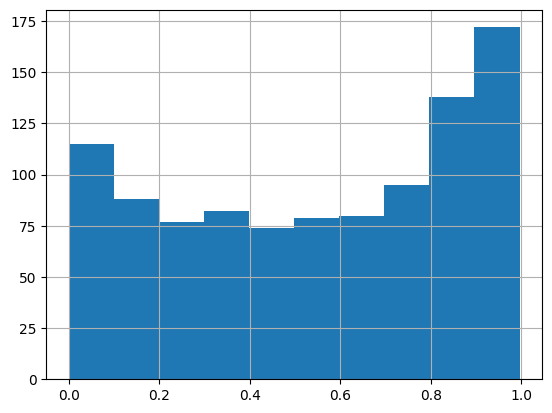

In [6]:
data_df['true_negative_rate'].hist(bins=10)

### Hypothesis Conclusion 1

The thresholds for each class have to be set higher to reduce the high number of false positives.

### Hypothesis 2

With the appropriate threshold set, a much better true negative rate that does not come at the expense of macro recall score can be found. The true negative rate of the threshold that produced the best macro recall score should be promising enough for this CLIP robustness check method to be confidently used.

By using a series of thresholds, a precision-recall curve can be plotted. The series of thresholds can be derived from using 100 percentile points of the sorted training images cosine similarity scores as seen in the diagram below.

<img src="robustness_check_diagrams/hypothesis2_diagram.png" alt="Hypothesis 2 Diagram" style="background-color:white; padding:20px" width=1280 />

Get class names from previous dataframe.

In [7]:
df = data_df[['class_name']].copy().reset_index(drop=True)
df.head()

,class_name
0,bison
1,goldfinch
2,lorikeet
3,geyser
4,chickadee


Get id to class name mapping.

In [8]:
with open(class_mapping_path) as f:
    mapping = json.load(f)

class_to_id = {v[0]: k for k, v in mapping.items()}
df["class_id"] = df["class_name"].map(class_to_id)
df.head()

,class_name,class_id
0,bison,n02410509
1,goldfinch,n01531178
2,lorikeet,n01820546
3,geyser,n09288635
4,chickadee,n01592084


Get the lowest cosine similarity score for training images inside class.

In [9]:
with open(lowest_train_thresholds_path) as f:
    lowest_thresholds = json.load(f)

df["train_inside_lowest_cos_sim"] = df["class_name"].map(lowest_thresholds)
df.head()

,class_name,class_id,train_inside_lowest_cos_sim
0,bison,n02410509,0.181046
1,goldfinch,n01531178,0.176837
2,lorikeet,n01820546,0.188692
3,geyser,n09288635,0.187150
4,chickadee,n01592084,0.190528


Function to calculate precision and recall related metrics.

In [10]:
def get_cm_metrics(
    threshold,
    val_in_class_cos_sim,
    val_out_class_cos_sim,
):
    true_positive = len([x for x in val_in_class_cos_sim if x > threshold])
    true_negative = len([x for x in val_out_class_cos_sim if x < threshold])

    false_positive = len(val_out_class_cos_sim) - true_negative
    false_negative = len(val_in_class_cos_sim) - true_positive

    return true_positive, true_negative, false_positive, false_negative

def get_precision_recall_metrics(true_positive, true_negative, false_positive, false_negative):
    # Precision for positive class
    if true_positive + false_positive == 0:
        positive_predictive_value = 0
    else:
        positive_predictive_value = true_positive / (true_positive + false_positive)
    
    # Precision for negative class
    if true_negative + false_negative == 0:
        negative_predictive_value = 0
    else:
        negative_predictive_value = true_negative / (true_negative + false_negative)

    # Recall for positive class
    if true_positive + false_negative == 0:
        true_positive_rate = 0
    else:
        true_positive_rate = true_positive / (true_positive + false_negative)

    # Recall for negative class
    if true_negative + false_positive == 0:
        true_negative_rate = 0
    else:
        true_negative_rate = true_negative / (true_negative + false_positive)

    # Macro or unweighted metrics
    macro_precision = (positive_predictive_value + negative_predictive_value) / 2
    macro_recall = (true_positive_rate + true_negative_rate) / 2

    return (
        positive_predictive_value,
        negative_predictive_value,
        true_positive_rate,
        true_negative_rate,
        macro_precision,
        macro_recall,
    )

Function to get a series of thresholds, calculate area under precision-recall curve for each threshold, and saving the metrics.

In [11]:
def get_area_under_prc(row, save_metrics=True, plot_pr=False):
    class_name = row["class_name"]
    class_id = class_to_id[class_name]
    with open(f'{val_robustness_folder}/{class_id}.json') as f:
        val_class_data = json.load(f)
    with open(f'{train_robustness_folder}/{class_id}.json') as f:
        train_class_data = json.load(f)

    train_inside_lowest_cos_sim = row["train_inside_lowest_cos_sim"]

    train_cos_sim = [v for (k,v) in train_class_data['cos_sim'].items()]
    val_in_class_cos_sim = [v for (k,v) in val_class_data['in_class'].items()]
    val_out_class_cos_sim = [v for (k,v) in val_class_data['outside_class'].items()]

    train_index_percentiles = [x*len(train_cos_sim)//100 for x in range(0,100)]
    percentile_thresholds = [train_cos_sim[x] for x in train_index_percentiles]
    percentile_thresholds.append(train_inside_lowest_cos_sim)

    # Macro
    precision_scores = []
    recall_scores = []

    if save_metrics:
        threshold_scores_dict = {}

    for idx, threshold in enumerate(percentile_thresholds):
        tp, tn, fp, fn = get_cm_metrics(
            threshold,
            val_in_class_cos_sim,
            val_out_class_cos_sim,
        )

        ppv, npv, tpr, tnr, precision, recall = get_precision_recall_metrics(
            tp, tn, fp, fn
        )

        # Use positive class precision and recall instead of macro
        # for PR AUC calculations
        # precision_scores.append(precision)
        # recall_scores.append(recall)
        precision_scores.append(ppv)
        recall_scores.append(tpr)

        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0
        acc = (tp + tn) / (tp + tn + fp + fn) if tp + tn + fp + fn != 0 else 0

        if save_metrics:
            threshold_scores_dict[f"{100 - idx} Percentile"] = {
                "threshold": threshold,
                "true_positive": tp,
                "true_negative": tn,
                "false_positive": fp,
                "false_negative": fn,
                "precision": precision, # macro precision
                "recall": recall, # macro recall
                "f1": f1, # macro f1
                "accuracy": acc,
                "ppv": ppv, # positive predictive value (precision for positive class)
                "npv": npv, # negative predictive value (precision for negative class)
                "tpr": tpr, # true positive rate (recall for positive class)
                "tnr": tnr, # true negative rate (recall for negative class)
            }

    sorted_scores = sorted(zip(recall_scores, precision_scores), key=lambda x: x[0])
    sorted_recall_scores = [x[0] for x in sorted_scores]
    sorted_precision_scores = [x[1] for x in sorted_scores]
    auc_score = auc(sorted_recall_scores, sorted_precision_scores)

    if save_metrics:
        metrics = {
            # "Macro PR AUC": auc_score,
            "Positive Class PR AUC": auc_score,
            "Metrics per Threshold": threshold_scores_dict,
        }
        with open(f"../data/from_server/robustness_check/val_metrics/{class_id}.json", "w") as f:
            json.dump(metrics, f, indent=4)
    else:
        # print(f"Macro PR AUC: {auc_score}")
        print(f"Positive Class PR AUC: {auc_score}")
    
    if plot_pr:
        pr_display = PrecisionRecallDisplay(
            precision=sorted_precision_scores,
            recall=sorted_recall_scores,
        )
        pr_display.plot()
    else:
        return auc_score
   

Make directory for validation data metrics if not created yet.

In [12]:
makedirs("../data/from_server/robustness_check/val_metrics", exist_ok=True)

Loop through df to save metrics for every class.

In [13]:
df["auc_score"] = df.apply(get_area_under_prc, axis=1)
df.head(10)

,class_name,class_id,train_inside_lowest_cos_sim,auc_score
0,bison,n02410509,0.181046,0.746752
1,goldfinch,n01531178,0.176837,0.935946
2,lorikeet,n01820546,0.188692,0.959554
3,geyser,n09288635,0.187150,0.977388
4,chickadee,n01592084,0.190528,0.988868
5,hartebeest,n02422106,0.181150,0.923535
6,box turtle,n01669191,0.185902,0.638522
7,tarantula,n01774750,0.189787,0.905640
8,steam locomotive,n04310018,0.171993,0.919409
9,triceratops,n01704323,0.170069,0.961733


View sample positive class precision-recall curve for a class.

butcher shop n02927161
Positive Class PR AUC: 0.5824053896948505


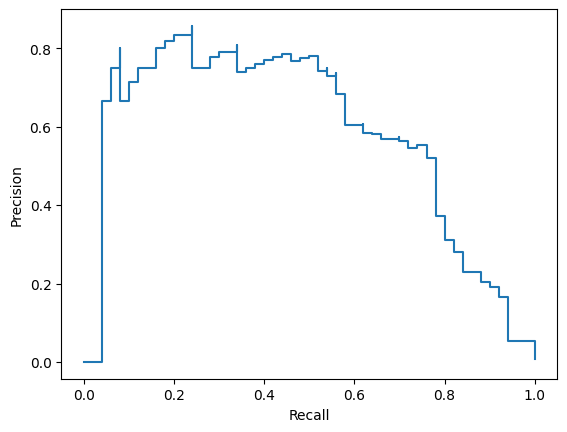

In [14]:
random_row = df.sample().iloc[0]
print(random_row["class_name"], random_row["class_id"])
get_area_under_prc(random_row, save_metrics=False, plot_pr=True)

Function to find the best recall and the corresponding true negative rate.

In [15]:
def get_true_negative_rate_of_best_recall(class_id):
    with open(f"../data/from_server/robustness_check/val_metrics/{class_id}.json") as f:
        metrics = json.load(f)

    recall_scores = [x["recall"] for x in metrics["Metrics per Threshold"].values()]
    index_of_best_recall = recall_scores.index(max(recall_scores))

    true_negative_rate = [x["tnr"] for x in metrics["Metrics per Threshold"].values()]
    return true_negative_rate[index_of_best_recall]

def get_best_recall(class_id):
    with open(f"../data/from_server/robustness_check/val_metrics/{class_id}.json") as f:
        metrics = json.load(f)
    
    recall_scores = [x["recall"] for x in metrics["Metrics per Threshold"].values()]
    return max(recall_scores)

df["best_recall"] = df["class_id"].map(get_best_recall)
df["true_negative_rate_of_best_recall"] = df["class_id"].map(get_true_negative_rate_of_best_recall)
df.head(10)

,class_name,class_id,train_inside_lowest_cos_sim,auc_score,best_recall,true_negative_rate_of_best_recall
0,bison,n02410509,0.181046,0.746752,0.989339,0.998679
1,goldfinch,n01531178,0.176837,0.935946,0.999660,0.999319
2,lorikeet,n01820546,0.188692,0.959554,0.999960,0.999920
3,geyser,n09288635,0.187150,0.977388,0.999950,0.999900
4,chickadee,n01592084,0.190528,0.988868,0.999970,0.999940
5,hartebeest,n02422106,0.181150,0.923535,0.999339,0.998679
6,box turtle,n01669191,0.185902,0.638522,0.998689,0.997377
7,tarantula,n01774750,0.189787,0.905640,0.999600,0.999199
8,steam locomotive,n04310018,0.171993,0.919409,0.995926,0.991852
9,triceratops,n01704323,0.170069,0.961733,0.995896,0.991792


With the correct threshold set, the percentage of correctly rejected images observed a very favourable increase as compared to using the lowest train image cosine similarity in hypothesis 1.

In [16]:
pd.DataFrame(df["true_negative_rate_of_best_recall"].describe())

,true_negative_rate_of_best_recall
count,1000.000000
mean,0.971588
std,0.050318
min,0.404505
25%,0.968383
50%,0.985465
75%,0.995135
max,1.000000


95% of 1000 classes now have more than 90% of the images correctly rejected.

In [17]:
df.sort_values(by=['true_negative_rate_of_best_recall'], ascending=False, inplace=True)
pd.DataFrame(df["true_negative_rate_of_best_recall"].describe(percentiles=[0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4]))

,true_negative_rate_of_best_recall
count,1000.000000
mean,0.971588
std,0.050318
min,0.404505
1%,0.715915
2%,0.827288
3%,0.857431
4%,0.887758
5%,0.903699
10%,0.940501


95% of the 1000 classes also have a macro recall score of more than 90%.

In [18]:
pd.DataFrame(df["best_recall"].describe(percentiles=[0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75]))

,best_recall
count,1000.000000
mean,0.970674
std,0.043695
min,0.566326
1%,0.756324
2.5%,0.836111
5%,0.901820
10%,0.934164
20%,0.959930
30%,0.970700


### Hypothesis 2 Conclusion

For an overwhelming majority of the 1000 classes, it is possible to drastically reduce the number of false positives with the appropriate threshold while still maintaining a very high macro recall score.

### Hypothesis 3

For every class, the macro recall score for a predetermined percentile threshold should not be too far off from the best macro recall score.

This predetermined percentile threshold can be used in two ways:
1) For a new class of images, a check can be done against the validation images of existing classes to see if the validation images fit within the expected number as a negative class.
2) For new images to be added to an existing class, a check can be also done against the training images of the existing class to see if the new images fit within the expected number as a positive class.

In [19]:
subset_df = df[["class_name", "class_id", "best_recall", "true_negative_rate_of_best_recall"]].copy().reset_index(drop=True)
subset_df["best_recall_tnr"] = subset_df["true_negative_rate_of_best_recall"]
subset_df.drop(columns=["true_negative_rate_of_best_recall"], inplace=True)
print(subset_df.shape)
subset_df.head()

(1000, 4)


,class_name,class_id,best_recall,best_recall_tnr
0,yellow lady's slipper,n12057211,1.00000,1.00000
1,indigo bunting,n01537544,0.98999,0.99998
2,chickadee,n01592084,0.99997,0.99994
3,echidna,n01872401,0.99997,0.99994
4,lorikeet,n01820546,0.99996,0.99992


In [20]:
per_class_df = subset_df.copy()
macro_df = subset_df.copy()

Functions to get metrics of specified percentile.

In [21]:
def get_metric_at_percentile(class_id, percentile, metric):
    with open(f"../data/from_server/robustness_check/val_metrics/{class_id}.json") as f:
        metrics = json.load(f)
    
    metric_score = metrics["Metrics per Threshold"][f"{percentile} Percentile"][metric]
    return metric_score

Iteratively get metrics at each percentile.

In [22]:
percentiles = list(range(0, 101, 5))

for percentile in percentiles:
    macro_df[f"{percentile}_f1"] = macro_df["class_id"].map(lambda x: get_metric_at_percentile(x, percentile, "f1"))
    macro_df[f"{percentile}_recall"] = macro_df["class_id"].map(lambda x: get_metric_at_percentile(x, percentile, "recall"))
    macro_df[f"{percentile}_precision"] = macro_df["class_id"].map(lambda x: get_metric_at_percentile(x, percentile, "precision"))
    macro_df[f"{percentile}_accuracy"] = macro_df["class_id"].map(lambda x: get_metric_at_percentile(x, percentile, "accuracy"))
    per_class_df[f"{percentile}_tnr"] = per_class_df["class_id"].map(lambda x: get_metric_at_percentile(x, percentile, "tnr"))
    per_class_df[f"{percentile}_tpr"] = per_class_df["class_id"].map(lambda x: get_metric_at_percentile(x, percentile, "tpr"))
    per_class_df[f"{percentile}_ppv"] = per_class_df["class_id"].map(lambda x: get_metric_at_percentile(x, percentile, "ppv"))
    per_class_df[f"{percentile}_npv"] = per_class_df["class_id"].map(lambda x: get_metric_at_percentile(x, percentile, "npv"))

macro_df.head(10)

,class_name,class_id,best_recall,best_recall_tnr,0_f1,0_recall,0_precision,0_accuracy,5_f1,5_recall,...,90_precision,90_accuracy,95_f1,95_recall,95_precision,95_accuracy,100_f1,100_recall,100_precision,100_accuracy
0,yellow lady's slipper,n12057211,1.00000,1.00000,0.663288,0.961161,0.506361,0.92240,1.000000,1.00000,...,0.99951,0.99902,0.675385,0.51000,0.999510,0.99902,0.49975,0.5,0.4995,0.999
1,indigo bunting,n01537544,0.98999,0.99998,0.662999,0.960390,0.506239,0.92086,0.979573,0.96000,...,0.99955,0.99910,0.692698,0.53000,0.999530,0.99906,0.49975,0.5,0.4995,0.999
2,chickadee,n01592084,0.99997,0.99994,0.731947,0.997297,0.578125,0.99460,0.984757,0.97000,...,0.99955,0.99910,0.684098,0.52000,0.999520,0.99904,0.49975,0.5,0.4995,0.999
3,echidna,n01872401,0.99997,0.99994,0.636833,0.870901,0.501931,0.74206,0.981113,0.99996,...,0.89954,0.99906,0.640245,0.51999,0.832853,0.99902,0.49975,0.5,0.4995,0.999
4,lorikeet,n01820546,0.99996,0.99992,0.745820,0.997878,0.595420,0.99576,0.984859,0.97999,...,0.99958,0.99916,0.701186,0.54000,0.999540,0.99908,0.49975,0.5,0.4995,0.999
5,bullet train,n02917067,0.98996,0.99992,0.641140,0.886386,0.502193,0.77300,0.962997,0.98993,...,0.99959,0.99918,0.701186,0.54000,0.999540,0.99908,0.49975,0.5,0.4995,0.999
6,odometer,n03841143,0.98996,0.99992,0.654408,0.933654,0.503744,0.86744,0.886290,0.98968,...,0.99953,0.99906,0.499750,0.50000,0.499500,0.99900,0.49975,0.5,0.4995,0.999
7,black swan,n01860187,0.98996,0.99992,0.666843,0.969730,0.508133,0.93952,0.979674,0.96999,...,0.99954,0.99908,0.499750,0.50000,0.499500,0.99900,0.49975,0.5,0.4995,0.999
8,yurt,n04613696,0.99996,0.99992,0.632708,0.856216,0.501734,0.71272,0.942087,0.99986,...,0.99951,0.99902,0.675385,0.51000,0.999510,0.99902,0.49975,0.5,0.4995,0.999
9,geyser,n09288635,0.99995,0.99990,0.740685,0.997688,0.588968,0.99538,0.975246,0.97997,...,0.49950,0.99900,0.499750,0.50000,0.499500,0.99900,0.49975,0.5,0.4995,0.999


In [23]:
per_class_df.head(10)

,class_name,class_id,best_recall,best_recall_tnr,0_tnr,0_tpr,0_ppv,0_npv,5_tnr,5_tpr,...,90_ppv,90_npv,95_tnr,95_tpr,95_ppv,95_npv,100_tnr,100_tpr,100_ppv,100_npv
0,yellow lady's slipper,n12057211,1.00000,1.00000,0.922322,1.0,0.012723,1.0,1.000000,1.00,...,1.0,0.99902,1.00000,0.02,1.000000,0.99902,1.0,0.0,0.0,0.999
1,indigo bunting,n01537544,0.98999,0.99998,0.920781,1.0,0.012478,1.0,1.000000,0.92,...,1.0,0.99910,1.00000,0.06,1.000000,0.99906,1.0,0.0,0.0,0.999
2,chickadee,n01592084,0.99997,0.99994,0.994595,1.0,0.156250,1.0,1.000000,0.94,...,1.0,0.99910,1.00000,0.04,1.000000,0.99904,1.0,0.0,0.0,0.999
3,echidna,n01872401,0.99997,0.99994,0.741802,1.0,0.003862,1.0,0.999920,1.00,...,0.8,0.99908,0.99998,0.04,0.666667,0.99904,1.0,0.0,0.0,0.999
4,lorikeet,n01820546,0.99996,0.99992,0.995756,1.0,0.190840,1.0,0.999980,0.96,...,1.0,0.99916,1.00000,0.08,1.000000,0.99908,1.0,0.0,0.0,0.999
5,bullet train,n02917067,0.98996,0.99992,0.772773,1.0,0.004386,1.0,0.999860,0.98,...,1.0,0.99918,1.00000,0.08,1.000000,0.99908,1.0,0.0,0.0,0.999
6,odometer,n03841143,0.98996,0.99992,0.867307,1.0,0.007487,1.0,0.999359,0.98,...,1.0,0.99906,1.00000,0.00,0.000000,0.99900,1.0,0.0,0.0,0.999
7,black swan,n01860187,0.98996,0.99992,0.939459,1.0,0.016265,1.0,0.999980,0.94,...,1.0,0.99908,1.00000,0.00,0.000000,0.99900,1.0,0.0,0.0,0.999
8,yurt,n04613696,0.99996,0.99992,0.712432,1.0,0.003469,1.0,0.999720,1.00,...,1.0,0.99902,1.00000,0.02,1.000000,0.99902,1.0,0.0,0.0,0.999
9,geyser,n09288635,0.99995,0.99990,0.995375,1.0,0.177936,1.0,0.999940,0.96,...,0.0,0.99900,1.00000,0.00,0.000000,0.99900,1.0,0.0,0.0,0.999


Get statistical descriptions of the per class metrics.

In [24]:
per_class_desc = per_class_df.describe()
per_class_desc

,best_recall,best_recall_tnr,0_tnr,0_tpr,0_ppv,0_npv,5_tnr,5_tpr,5_ppv,5_npv,...,90_ppv,90_npv,95_tnr,95_tpr,95_ppv,95_npv,100_tnr,100_tpr,100_ppv,100_npv
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,0.970674,0.971588,0.545826,0.999280,0.008419,0.999998,0.959871,0.941220,0.216964,0.999937,...,0.773496,0.999083,0.999704,0.039620,0.684938,0.999039,0.999995,0.00056,0.027000,0.999001
std,0.043695,0.050318,0.315367,0.004135,0.019290,0.000021,0.105832,0.045265,0.238075,0.000050,...,0.319445,0.000052,0.004553,0.033283,0.409739,0.000034,0.000083,0.00342,0.162164,0.000003
min,0.566326,0.404505,0.000040,0.960000,0.001000,0.999418,0.073273,0.540000,0.001057,0.999538,...,0.000000,0.998862,0.892513,0.000000,0.000000,0.998902,0.997457,0.00000,0.000000,0.998997
25%,0.966752,0.968383,0.255010,1.000000,0.001342,1.000000,0.976386,0.920000,0.037897,0.999919,...,0.600000,0.999040,0.999980,0.020000,0.333333,0.999020,1.000000,0.00000,0.000000,0.999000
50%,0.984249,0.985465,0.570390,1.000000,0.002325,1.000000,0.993303,0.940000,0.122237,0.999940,...,1.000000,0.999080,1.000000,0.040000,1.000000,0.999040,1.000000,0.00000,0.000000,0.999000
75%,0.993406,0.995135,0.848148,1.000000,0.006549,1.000000,0.998083,0.980000,0.326491,0.999978,...,1.000000,0.999119,1.000000,0.060000,1.000000,0.999060,1.000000,0.00000,0.000000,0.999000
max,1.000000,1.000000,0.995956,1.000000,0.196078,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.999340,1.000000,0.200000,1.000000,0.999200,1.000000,0.04000,1.000000,0.999040


Get statistical descriptions of the macro metrics.

In [25]:
macro_desc = macro_df.describe()
macro_desc

,best_recall,best_recall_tnr,0_f1,0_recall,0_precision,0_accuracy,5_f1,5_recall,5_precision,5_accuracy,...,90_precision,90_accuracy,95_f1,95_recall,95_precision,95_accuracy,100_f1,100_recall,100_precision,100_accuracy
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.970674,0.971588,0.604281,0.772553,0.504208,0.546280,0.736342,0.950546,0.608451,0.959853,...,0.886290,0.998567,0.633379,0.519662,0.841989,0.998744,0.504500,0.500278,0.513000,0.998996
std,0.043695,0.050318,0.055447,0.157459,0.009645,0.315051,0.088643,0.056335,0.119039,0.105724,...,0.159730,0.006997,0.076437,0.016862,0.204878,0.004550,0.028536,0.001711,0.081084,0.000083
min,0.566326,0.404505,0.500260,0.500020,0.500217,0.001040,0.513179,0.526637,0.500392,0.074180,...,0.499495,0.825120,0.476920,0.456256,0.499497,0.891640,0.499113,0.498729,0.499499,0.996460
25%,0.966752,0.968383,0.556958,0.627505,0.500671,0.255755,0.672635,0.944952,0.518910,0.976400,...,0.799530,0.999020,0.577707,0.509990,0.666177,0.999000,0.499750,0.500000,0.499500,0.999000
50%,0.984249,0.985465,0.611554,0.784329,0.501162,0.570820,0.710884,0.964284,0.561088,0.993230,...,0.999510,0.999060,0.675385,0.519990,0.999510,0.999020,0.499750,0.500000,0.499500,0.999000
75%,0.993406,0.995135,0.651432,0.922968,0.503274,0.848300,0.786142,0.978801,0.663223,0.998020,...,0.999540,0.999100,0.684098,0.530000,0.999520,0.999040,0.499750,0.500000,0.499500,0.999000
max,1.000000,1.000000,0.747891,0.997948,0.598039,0.995940,1.000000,1.000000,1.000000,1.000000,...,0.999660,0.999320,0.749887,0.600000,0.999600,0.999200,0.684098,0.520000,0.999520,0.999040


Plot mean TNR and TPR over percentiles.

Note: The straight diagonal line of the TPR shows that the spread of validation image set is similar to the training image set.

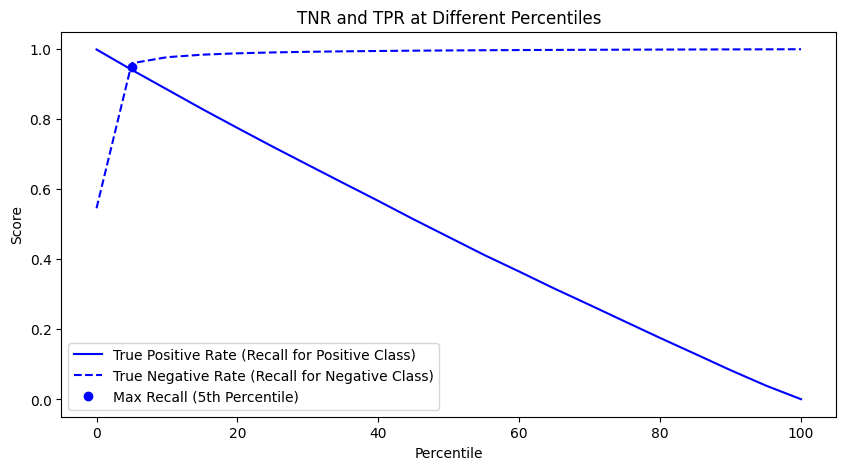

In [26]:
# Get y values for macro F1 and other
y_tnr = list(per_class_desc.loc["mean", [f"{x}_tnr" for x in percentiles]])
y_tpr = list(per_class_desc.loc["mean", [f"{x}_tpr" for x in percentiles]])

# Get max macro metrics and the corresponding percentiles
recall_scores = list(macro_desc.loc["mean", [f"{x}_recall" for x in percentiles]])
max_recall = max(recall_scores)
max_recall_percentile = percentiles[recall_scores.index(max_recall)]

recall_colour = "blue"

# Plot
plt.figure(figsize=(10,5))
plt.plot(percentiles, y_tpr, label="True Positive Rate (Recall for Positive Class)", color=recall_colour)
plt.plot(percentiles, y_tnr, "--",label="True Negative Rate (Recall for Negative Class)", color=recall_colour)
plt.plot(max_recall_percentile, max_recall, 'o', label=f"Max Recall ({max_recall_percentile}th Percentile)", color=recall_colour)
plt.title("TNR and TPR at Different Percentiles")
plt.xlabel("Percentile")
plt.ylabel("Score")
plt.legend()
plt.show()

The recall at the 5th percentile is not too far off from the best recall.

In [27]:
macro_desc[["best_recall", *[f"{x}_recall" for x in range(0, 101, 5)]]]

,best_recall,0_recall,5_recall,10_recall,15_recall,20_recall,25_recall,30_recall,35_recall,40_recall,...,55_recall,60_recall,65_recall,70_recall,75_recall,80_recall,85_recall,90_recall,95_recall,100_recall
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.970674,0.772553,0.950546,0.931251,0.906829,0.881776,0.856333,0.831246,0.806049,0.780894,...,0.704930,0.681349,0.657213,0.634086,0.610605,0.587239,0.564459,0.541481,0.519662,0.500278
std,0.043695,0.157459,0.056335,0.049775,0.050833,0.052889,0.055075,0.056616,0.057961,0.057463,...,0.056166,0.054388,0.051221,0.047553,0.044024,0.039108,0.033143,0.026068,0.016862,0.001711
min,0.566326,0.500020,0.526637,0.538889,0.527638,0.546156,0.549980,0.540000,0.532082,0.538539,...,0.499590,0.465175,0.449700,0.452242,0.454024,0.438609,0.442623,0.442943,0.456256,0.498729
25%,0.966752,0.627505,0.944952,0.916444,0.881496,0.849980,0.827868,0.799815,0.770000,0.749222,...,0.669897,0.640000,0.619990,0.600000,0.579990,0.559990,0.540000,0.520000,0.509990,0.500000
50%,0.984249,0.784329,0.964284,0.939575,0.916717,0.889434,0.859915,0.836101,0.809785,0.779950,...,0.700000,0.679955,0.659705,0.630000,0.609950,0.580000,0.560000,0.539990,0.519990,0.500000
75%,0.993406,0.922968,0.978801,0.959782,0.939545,0.918208,0.889955,0.869782,0.839982,0.819592,...,0.739960,0.719850,0.689982,0.660000,0.639960,0.610000,0.580000,0.559702,0.530000,0.500000
max,1.000000,0.997948,1.000000,0.999700,0.999780,0.999890,0.998929,0.999229,0.989510,0.959199,...,0.899700,0.879810,0.849910,0.829950,0.779980,0.759990,0.719930,0.669980,0.600000,0.520000


Taking a closer look at macro metrics for the 5th percentile threshold.

In [28]:
macro_df_5th = macro_desc[[f"5_{x}" for x in ["f1", "recall", "precision"]]].copy()
per_class_df_5th = per_class_desc[[f"5_{x}" for x in ["tnr", "tpr", "ppv", "npv"]]].copy()

# Merge two df
desc_df_5th = pd.concat([macro_df_5th, per_class_df_5th], axis=1)
desc_df_5th

,5_f1,5_recall,5_precision,5_tnr,5_tpr,5_ppv,5_npv
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.736342,0.950546,0.608451,0.959871,0.941220,0.216964,0.999937
std,0.088643,0.056335,0.119039,0.105832,0.045265,0.238075,0.000050
min,0.513179,0.526637,0.500392,0.073273,0.540000,0.001057,0.999538
25%,0.672635,0.944952,0.518910,0.976386,0.920000,0.037897,0.999919
50%,0.710884,0.964284,0.561088,0.993303,0.940000,0.122237,0.999940
75%,0.786142,0.978801,0.663223,0.998083,0.980000,0.326491,0.999978
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Looking at the 5th percentile cosine similarity values for every class.

In [34]:
subset_df["5th Percentile Cosine Similarity"] = subset_df["class_id"].map(lambda x: get_metric_at_percentile(x, 5, "threshold"))
subset_df.head()

,class_name,class_id,best_recall,best_recall_tnr,5th Percentile Cosine Similarity
0,yellow lady's slipper,n12057211,1.00000,1.00000,0.239009
1,indigo bunting,n01537544,0.98999,0.99998,0.259580
2,chickadee,n01592084,0.99997,0.99994,0.252983
3,echidna,n01872401,0.99997,0.99994,0.246562
4,lorikeet,n01820546,0.99996,0.99992,0.250141


Looking at the descriptive statistics for the 5th percentile cosine similarity values for every class and concluded that there is no single cosine similarity value that can be used as a threshold because of variations across classes.

In [42]:
subset_df[["5th Percentile Cosine Similarity"]].describe(percentiles=[0.025, 0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 0.95])

,5th Percentile Cosine Similarity
count,1000.000000
mean,0.192274
std,0.026587
min,0.098084
2.5%,0.136932
5%,0.147770
10%,0.159272
20%,0.170108
25%,0.175097
30%,0.178095


### Hypothesis 3 Conclusion

A threshold for robustness check can be set at the 5th percentile of sorted training image cosine similarity scores.

Based on the 5th percentile metrics from the imagenet dataset:
- For a new class of images, based on the mean TNR of 96% it is expected for roughly 4% of the validation images of existing classes to be above the threshold. Manual checks will only be required if more than 4% of images of the existing validation images have a higher cosine similarity than the threshold.
  - New classes should have at least 100 images
- For new images to be added to an existing class, based on the mean TPR of 94% it is expected for roughly 6% of the new images to have cosine similarity scores that fall below the threshold. Manual checks will only be required if the set of new images has more than 6% of images that have a lower cosine similarity than the threshold.
  - New images to existing classes can be any number

For convenience, a single threshold of 5% is recommended for the CLIP robustness checks on new image classes and new images to existing classes.

### Other Observations

Focusing on the recall metrics for a partcular class.

[0.9294294294294294, 0.9996596596596596, 0.9998998998998999, 0.9999399399399399, 0.99997997997998, 0.99997997997998, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 0.82, 0.74, 0.74, 0.66, 0.62, 0.6, 0.48, 0.46, 0.44, 0.34, 0.32, 0.32, 0.28, 0.2, 0.18, 0.16, 0.08, 0.02, 0.0]
[0.9647147147147147, 0.9998298298298298, 0.9099499499499499, 0.8699699699699699, 0.86998998998999, 0.8299899899899901, 0.81, 0.8, 0.74, 0.73, 0.72, 0.67, 0.66, 0.66, 0.64, 0.6, 0.59, 0.58, 0.54, 0.51, 0.5]


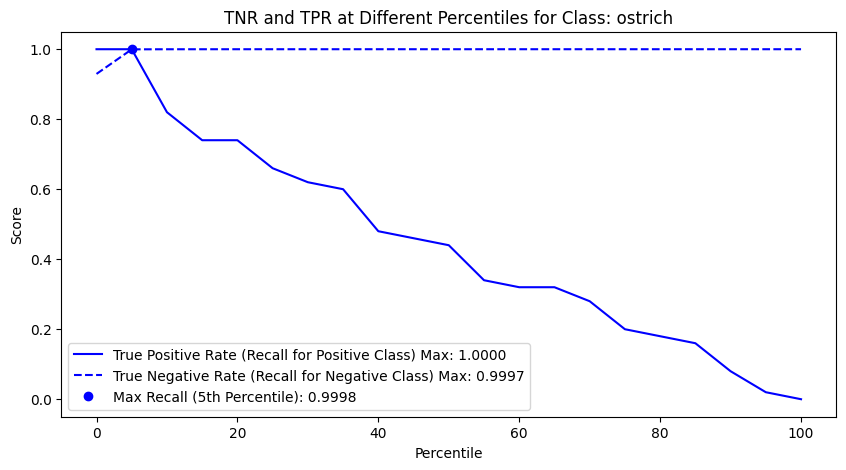

In [29]:
class_name = "ostrich"

# Get y values for macro F1 and other
y_tnr =  [list(d.values())[0] for d in per_class_df[per_class_df["class_name"] == class_name][[f"{x}_tnr" for x in percentiles]].to_dict().values()]
y_tpr =  [list(d.values())[0] for d in per_class_df[per_class_df["class_name"] == class_name][[f"{x}_tpr" for x in percentiles]].to_dict().values()]
recall_scores = [list(d.values())[0] for d in macro_df[macro_df["class_name"] == class_name][[f"{x}_recall" for x in percentiles]].to_dict().values()]
print(y_tnr)
print(y_tpr)
print(recall_scores)

# Get max macro metrics and the corresponding percentiles
recall_scores = [list(d.values())[0] for d in macro_df[macro_df["class_name"] == class_name][[f"{x}_recall" for x in percentiles]].to_dict().values()]
max_recall = max(recall_scores)
max_recall_index = recall_scores.index(max_recall)
max_recall_percentile = percentiles[max_recall_index]

recall_colour = "blue"

# Plot
plt.figure(figsize=(10,5))
plt.plot(percentiles, y_tpr, label=f"True Positive Rate (Recall for Positive Class) Max: {y_tpr[max_recall_index]:.4f}", color=recall_colour)
plt.plot(percentiles, y_tnr, "--",label=f"True Negative Rate (Recall for Negative Class) Max: {y_tnr[max_recall_index]:.4f}", color=recall_colour)
plt.plot(max_recall_percentile, max_recall, 'o', label=f"Max Recall ({max_recall_percentile}th Percentile): {max_recall:.4f}", color=recall_colour)
plt.title(f"TNR and TPR at Different Percentiles for Class: {class_name}")
plt.xlabel("Percentile")
plt.ylabel("Score")
plt.legend()
plt.show()

Visualising other metrics. 

- Positive predictive value observes a sharp fall at higher percentiles likely because the highest cosine similarity scores for the training images are higher than any of the cosine similarity scores for the validation images for majority of the classes.
- There are high values for negative predictive value regardless of percentile because of the sheer number of negative classes.
- Accuracy is skewed towards 100 percentile because of the highly imbalanced nature of each class when 999 other classes are used as negative class.

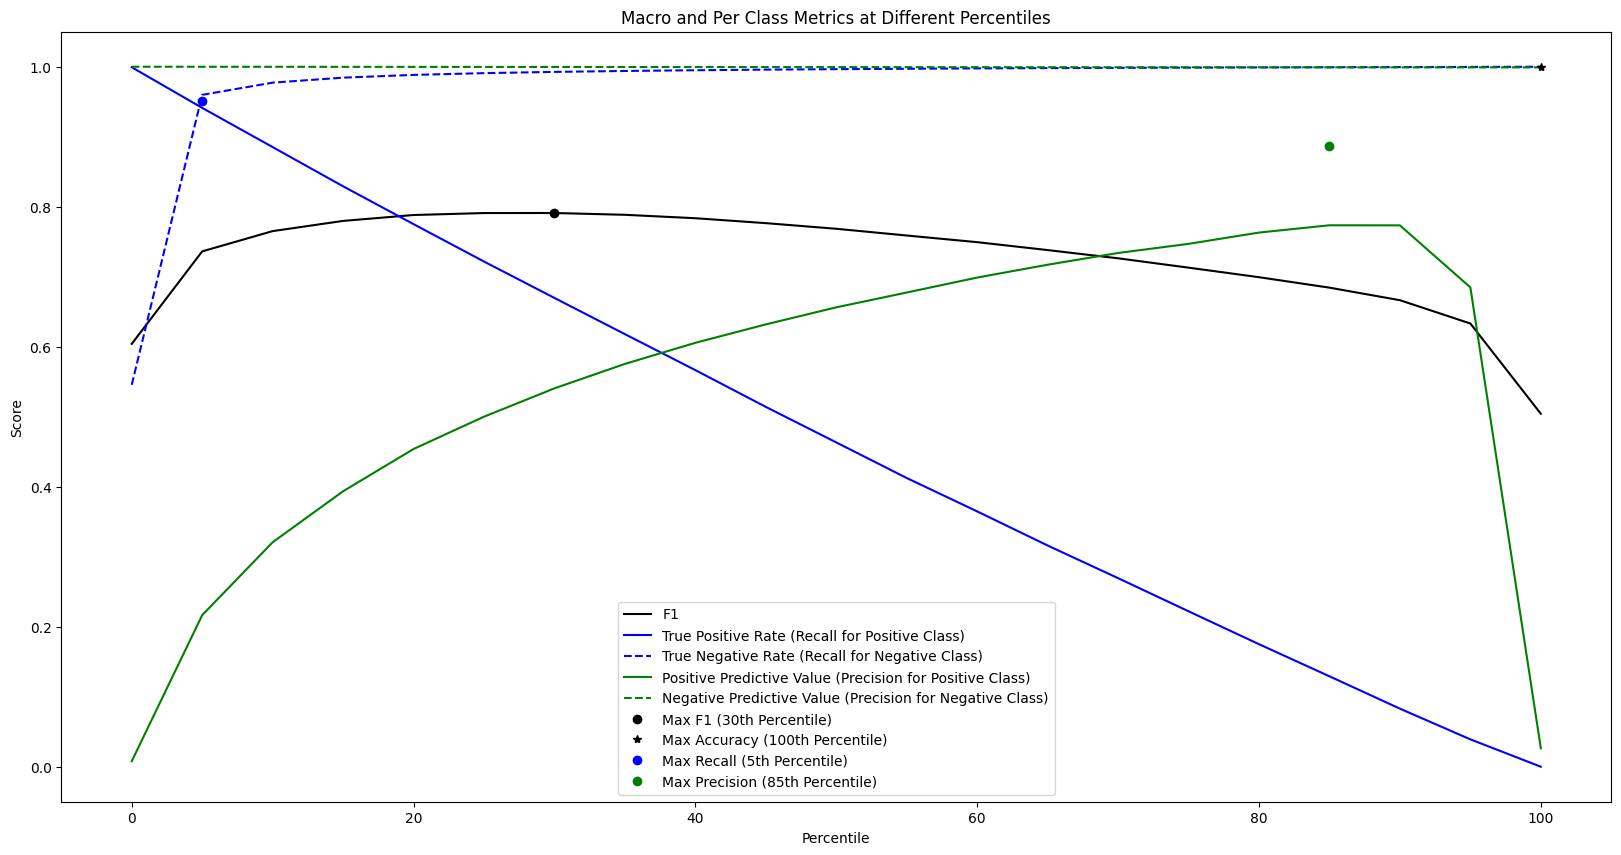

In [30]:
# Get y values for macro F1 and other
y_f1 = list(macro_desc.loc["mean", [f"{x}_f1" for x in percentiles]])
y_tnr = list(per_class_desc.loc["mean", [f"{x}_tnr" for x in percentiles]])
y_tpr = list(per_class_desc.loc["mean", [f"{x}_tpr" for x in percentiles]])
y_ppv = list(per_class_desc.loc["mean", [f"{x}_ppv" for x in percentiles]])
y_npv = list(per_class_desc.loc["mean", [f"{x}_npv" for x in percentiles]])

# Get max macro metrics and the corresponding percentiles
max_f1 = max(y_f1)
max_f1_percentile = percentiles[y_f1.index(max_f1)]
acc_scores = list(macro_desc.loc["mean", [f"{x}_accuracy" for x in percentiles]])
max_acc = max(acc_scores)
max_acc_percentile = percentiles[acc_scores.index(max_acc)]
recall_scores = list(macro_desc.loc["mean", [f"{x}_recall" for x in percentiles]])
max_recall = max(recall_scores)
max_recall_percentile = percentiles[recall_scores.index(max_recall)]
precision_scores = list(macro_desc.loc["mean", [f"{x}_precision" for x in percentiles]])
max_precision = max(precision_scores)
max_precision_percentile = percentiles[precision_scores.index(max_precision)]

f1_colour = "black"
recall_colour = "blue"
precision_colour = "green"

# Plot
plt.figure(figsize=(20, 10))
plt.plot(percentiles, y_f1, label="F1", color=f1_colour)
plt.plot(percentiles, y_tpr, label="True Positive Rate (Recall for Positive Class)", color=recall_colour)
plt.plot(percentiles, y_tnr, "--",label="True Negative Rate (Recall for Negative Class)", color=recall_colour)
plt.plot(percentiles, y_ppv, label="Positive Predictive Value (Precision for Positive Class)", color=precision_colour)
plt.plot(percentiles, y_npv, "--",label="Negative Predictive Value (Precision for Negative Class)", color=precision_colour)
plt.plot(max_f1_percentile, max_f1, 'o', label=f"Max F1 ({max_f1_percentile}th Percentile)", color=f1_colour)
plt.plot(max_acc_percentile, max_acc, '*', label=f"Max Accuracy ({max_acc_percentile}th Percentile)", color=f1_colour)
plt.plot(max_recall_percentile, max_recall, 'o', label=f"Max Recall ({max_recall_percentile}th Percentile)", color=recall_colour)
plt.plot(max_precision_percentile, max_precision, 'o', label=f"Max Precision ({max_precision_percentile}th Percentile)", color=precision_colour)
plt.title("Macro and Per Class Metrics at Different Percentiles")
plt.xlabel("Percentile")
plt.ylabel("Score")
plt.legend()
plt.show()

Observing precision and recall more closely at macro and per class level.

In [31]:
sample_percentiles = list(range(0, 101, 5)) 

sample_recall = list(macro_desc.loc["mean", [f"{x}_recall" for x in sample_percentiles]])
sample_tnr = list(per_class_desc.loc["mean", [f"{x}_tnr" for x in sample_percentiles]])
sample_tpr = list(per_class_desc.loc["mean", [f"{x}_tpr" for x in sample_percentiles]])

sample_precision = list(macro_desc.loc["mean", [f"{x}_precision" for x in sample_percentiles]])
sample_npv = list(per_class_desc.loc["mean", [f"{x}_npv" for x in sample_percentiles]])
sample_ppv = list(per_class_desc.loc["mean", [f"{x}_ppv" for x in sample_percentiles]])

sample_recall = [round(x, 3) for x in sample_recall]
sample_tnr = [round(x, 3) for x in sample_tnr]
sample_tpr = [round(x, 3) for x in sample_tpr]

sample_precision = [round(x, 3) for x in sample_precision]
sample_npv = [round(x, 3) for x in sample_npv]
sample_ppv = [round(x, 3) for x in sample_ppv]

print(f"Sample Percentiles: {sample_percentiles} \n")
print(f"Sample Recall: {sample_recall}")
print(f"Sample TNR: {sample_tnr}")
print(f"Sample TPR: {sample_tpr}\n")
print(f"Sample Precision: {sample_precision}")
print(f"Sample NPV: {sample_npv}")
print(f"Sample PPV: {sample_ppv}")

Sample Percentiles: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100] 

Sample Recall: [0.773, 0.951, 0.931, 0.907, 0.882, 0.856, 0.831, 0.806, 0.781, 0.755, 0.73, 0.705, 0.681, 0.657, 0.634, 0.611, 0.587, 0.564, 0.541, 0.52, 0.5]
Sample TNR: [0.546, 0.96, 0.977, 0.984, 0.988, 0.991, 0.993, 0.994, 0.995, 0.996, 0.997, 0.997, 0.998, 0.998, 0.998, 0.999, 0.999, 0.999, 0.999, 1.0, 1.0]
Sample TPR: [0.999, 0.941, 0.885, 0.829, 0.775, 0.722, 0.67, 0.618, 0.567, 0.514, 0.464, 0.413, 0.365, 0.316, 0.27, 0.223, 0.175, 0.13, 0.083, 0.04, 0.001]

Sample Precision: [0.504, 0.608, 0.66, 0.697, 0.727, 0.75, 0.77, 0.788, 0.803, 0.816, 0.828, 0.839, 0.849, 0.858, 0.867, 0.873, 0.881, 0.886, 0.886, 0.842, 0.513]
Sample NPV: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999, 0.999]
Sample PPV: [0.008, 0.217, 0.321, 0.394, 0.454, 0.5, 0.541, 0.576, 0.606, 0.632, 0.656, 0.678, 0.699, 0.717, 0.734, 0.74